In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.special import lpmn  # associated legendre polynomial in sequence

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "gtracr"))


from gtracr.trajectory import Trajectory
import gtracr.igrf_utils as iuf

In [3]:
# import gauss coefficients from shc file
current_year = 2015

leap_year = False
# check if we have a leap year or not
if current_year % 4 == 0:
    leap_year = True

data_path = os.path.join(os.getcwd(), "..", "..", "data", "IGRF13.shc")
igrf = iuf.load_shcfile(data_path, leap_year=leap_year)

In [4]:
# interpolate the model for more years
from scipy import interpolate
f = interpolate.interp1d(igrf.time, igrf.coeffs)

# get the coeffiecients for our year
coeffs = f(current_year).T
# print(coeffs)

In [5]:
# obtain the magnetic field components
EARTH_RADIUS = 6.3712 * (1e6)
num = 1000
r = EARTH_RADIUS  * (1e-3)  # start with constant radius for now
theta_arr = np.linspace(0., 180., num=num, endpoint=False)
phi_arr = np.linspace(-180., 180., num=num, endpoint=False)

Br, Btheta, Bphi = iuf.synth_values(coeffs, r, theta_arr, phi_arr, nmax=igrf.parameters['nmax'], grid=True)

# bfield_intensity = iuf.synth_values(coeffs, r_arr, theta_arr, phi_arr, nmax=igrf.parameters['nmax'], grid=True)

# print(B)
# print([bfield_intensity[num].shape for num in range(3)])

# print(Br, Btheta, Bphi)

/home/keito/devel/gtracr/tests/notebooks/../../gtracr/igrf_utils.py:402: UserWarning: The geographic poles are included.
  warnings.warn('The geographic poles are included.')


In [6]:
# plot the contour map of the IGRF B-field
# plot total intensity (magnitude of B-field) for different theta and phi

# create matrix elements of theta, phi
lat_arr = theta_arr - 90.  # translate to get latitude values 
lng_arr = phi_arr   # longitude follows [-180, 180] convention
lat_matrix, lng_matrix = np.meshgrid(lat_arr, lng_arr, indexing="ij")

# evaluate the total intensity, referred from IGRF 12 paper
bfield_intensity = np.sqrt(Br**2. + Btheta**2. + Bphi**2.)
# reverse matrix since values are given in B(theta, phi) not B(phi, theta)
bfield_intensity = bfield_intensity[::-1]  

print(bfield_intensity)
# print(theta_matrix)

[[54701.13004361 54700.86917629 54700.60309808 ... 54701.8812768
  54701.63610401 54701.3856896 ]
 [54832.67088544 54832.14657314 54831.61186878 ... 54834.18125906
  54833.68824909 54833.18478439]
 [54963.47795701 54962.68761713 54961.8817346  ... 54965.75539834
  54965.01187926 54964.2527217 ]
 ...
 [56375.13125719 56374.94517215 56374.75696527 ... 56375.67670641
  56375.49703174 56375.31521288]
 [56346.86617572 56346.77350842 56346.67974894 ... 56347.13758774
  56347.04821902 56346.95774714]
 [56318.41270047 56318.41270047 56318.41270047 ... 56318.41270047
  56318.41270047 56318.41270047]]


In [7]:
level_len = 18

bfield_intensity_list = np.linspace(
    np.min(bfield_intensity),
    np.max(bfield_intensity),
    num=level_len
)

In [8]:
'''
Below is for imshow with contour lines
'''

# fig, ax = plt.subplots(figsize=(12, 9), constrained_layout=True)
# fig = plt.figure(figsize=(12,9))
# ax = plt.subplot(111)

# image = ax.imshow(
#     bfield_intensity,
#     extent=[-182.5, 182.5, -92.5, 92.5], 
# #     extent=[0., 360., 0., 180.],
# #     extent=[-1, 361, -1, 181],
#     origin='lower',
#     cmap="RdBu_r",
#     interpolation="bicubic",
#     aspect="auto",
#     vmin=np.min(bfield_intensity),
#     vmax=np.max(bfield_intensity),
#     alpha=1.
# )
# ax.axis('image')

# contour = ax.contour(
#     lng_matrix,
#     lat_matrix,
#     bfield_intensity,
#     #  levels=rigidity_list,
#     colors="k",
# #     cmap="viridis",
#     linewidths=0.5,
# #     extent=[-5., 365., -5., 185.], 
# #      extent=[0., 360., 0., 180.],
# #     corner_mask=False,
#     extent=[-182.5, 182.5, -92.5, 92.5], 
#     levels=level_len,
#     alpha=1.
# )
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

# ax.clabel(contour, inline=1, fontsize=10.0)

# cbar = fig.colorbar(image, ax=ax, shrink=0.6)
# cbar.ax.set_ylabel("Total Intensity [nT]")

# ax.set_xlabel("Geographic Longitude [$^\circ$]")
# ax.set_ylabel("Geographic Latitude [$^\circ$]")
# ax.set_title("Total Intensity of Earth's Magnetic Field at r = {:.1f}km in {:d}".format(
#     r, current_year))

'\nBelow is for imshow with contour lines\n'

Text(0.5, 1.0, "Total Intensity of Earth's Magnetic Field at r = 6371.2km in 2015")

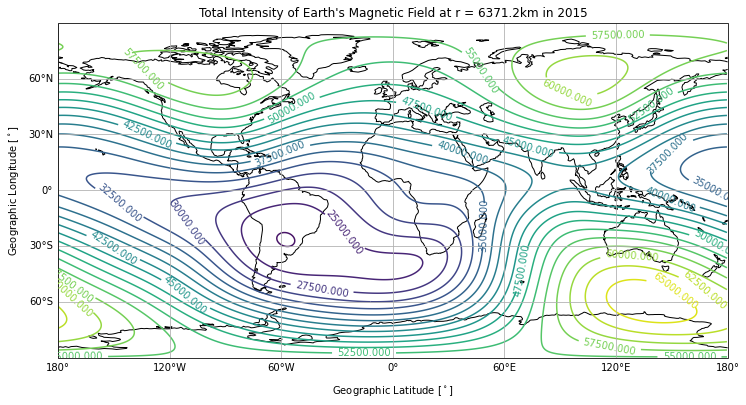

In [9]:
'''
Below is for contour plots with colored lines
with world map using cartopy
'''

# using cartopy to plot with world map in background
# to install this in ubuntu, the following procedure is required:
# apt-get install libproj-dev proj-data proj-bin  
# apt-get install libgeos-dev  
# pip install cython  
# pip install cartopy  
# a bit of a hassle but required if we want to plot world maps
# regularly, otherwise add this as an optional dependency
# to our package

from cartopy import crs as ccrs

fig = plt.figure(figsize=(12,9))
map_type = ccrs.PlateCarree()   # rectangular map
ax = plt.axes(projection=map_type)

# set extent of the plot to be full range
ax.set_extent([-180., 180., -90., 90.], map_type)
# draw the coastlines of the world
ax.coastlines()   
# draw the grid lines onto the axes
# and modify with options
# dms : enable dms notation or not
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels = False   # remove top labels
gl.right_labels = False   # remove right labels
ax.text(-0.055, 0.5, "Geographic Longitude [$^\circ$]", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.12, "Geographic Latitude [$^\circ$]", va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)


contour = ax.contour(
    lng_matrix,
    lat_matrix,
    bfield_intensity,
    #  levels=rigidity_list,
#     colors="k",
    cmap="viridis",
    linewidths=1.5,
#     extent=[-5., 365., -5., 185.], 
#      extent=[0., 360., 0., 180.],
#     corner_mask=False,
    levels=level_len,
    alpha=1.
)
# # divider = make_axes_locatable(ax)
# # cax = divider.append_axes("right", size="5%", pad=0.1)

ax.clabel(contour, inline=1, fontsize=10.0)

ax.set_xlabel("Geographic Longitude [$^\circ$]")
ax.set_ylabel("Geographic Latitude [$^\circ$]")
ax.set_title("Total Intensity of Earth's Magnetic Field at r = {:.1f}km in {:d}".format(
    r, current_year))

# fig.tight_layout()

Text(0.5, 1.0, "Total Intensity of Earth's Magnetic Field at r = 6371.2km in 2015")

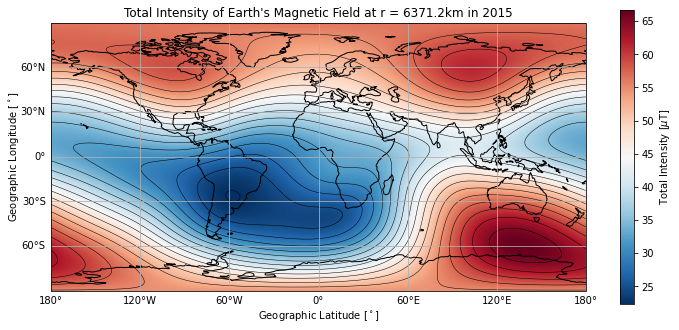

In [141]:
'''
Below is for contour plots with colored lines
with world map using cartopy
'''

# using cartopy to plot with world map in background
# to install this in ubuntu, the following procedure is required:
# apt-get install libproj-dev proj-data proj-bin  
# apt-get install libgeos-dev  
# pip install cython  
# pip install cartopy  
# a bit of a hassle but required if we want to plot world maps
# regularly, otherwise add this as an optional dependency
# to our package

from cartopy import crs as ccrs

fig = plt.figure(figsize=(12,9))
# create axes with different world map type
# as the projection
# list of projections: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
map_type = ccrs.PlateCarree()  
ax = plt.axes(projection=map_type)

# set extent of the plot
ax.set_extent([-180., 180., -90., 90.], map_type)
ax.coastlines()   # draw the coastlines of the world
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels = False   # remove top labels
gl.right_labels = False   # remove right labels

# the tick labels are used instead of name labels with cartopy
# as such, there is no nice feature to add name labels in axes
# as such, one has to resort to adding text to the axes 
# with manually setting the location of the text
# obtained from stack overflow: https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
ax.text(-0.055, 0.5, "Geographic Longitude [$^\circ$]", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.12, "Geographic Latitude [$^\circ$]", va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

image = ax.imshow(
    bfield_intensity * (1e-3),
    extent=[-180., 180., -90., 90.], 
#     extent=[0., 360., 0., 180.],
#     extent=[-1, 361, -1, 181],
    origin='lower',
    cmap="RdBu_r",
    interpolation="bicubic",
    aspect="auto",
    vmin=np.min(bfield_intensity)* (1e-3),
    vmax=np.max(bfield_intensity)* (1e-3),
    alpha=1.
)
ax.axis('image')

cbar = fig.colorbar(image, ax=ax, shrink=0.6)
cbar.ax.set_ylabel(r"Total Intensity [$\mu$T]")

contour = ax.contour(
    lng_matrix,
    lat_matrix,
    bfield_intensity,
    #  levels=rigidity_list,
    colors="k",
#     cmap="viridis",
    linewidths=0.5,
#     extent=[-5., 365., -5., 185.], 
#      extent=[0., 360., 0., 180.],
#     corner_mask=False,
#     extent=[-182.5, 182.5, -92.5, 92.5], 
    extent=[-180., 180., -90., 90.], 
    levels=level_len,
    alpha=1.
)

# cbar.set_clim([np.min(rigidity_list)-0.5, np.max(rigidity_list)+0.5])
# cbar.ax.set_ylim([np.min(rigidity_list)-0.5, np.max(rigidity_list)+0.5])

# ax.set_xlim([-180., 180.])
# ax.set_ylim([0., 180.])

# ax.set_xlabel("Geographic Longitude [$^\circ$]")
# ax.set_ylabel("Geographic Latitude [$^\circ$]")
ax.set_title("Total Intensity of Earth's Magnetic Field at r = {:.1f}km in {:d}".format(
    r, current_year))

# fig.tight_layout()

In [119]:
# where the data is stored
data_path = os.path.join(os.getcwd(), "..", "..", "data")
print(os.listdir(data_path))
# we want to store the data as a .json format
# so lets convert the original data, saved as a .txt file
# and save it as a .json file now.
N = 13   #the degree of truncation

yearly_coeffdict = {
    "g": {
        "values":np.zeros((N+1,N+1)).tolist(), 
        "svp":np.zeros((N+1, N+1)).tolist()
    },          
    "h": {
        "values":np.zeros((N+1,N+1)).tolist(), 
        "svp":np.zeros((N+1, N+1)).tolist()
    }  
}

with open(os.path.join(data_path, "IGRF13.txt"), "r") as f:
    for i, line in enumerate(f.readlines()):
        # skip if we see "#" symbol (indicates comments)
        # or any line before dates (extra information thats not needed)
        if line[0] == "#" or i < 4:  # a comment
            continue
        # get the years of the magnetic field coefficient data as keys to our dictionary
        # here we also construct 2 separate arrays for the 'g' and 'h' coefficients
        # presented as a 13x14 data structure (14 to account for m=0 case)
        # the matrix will be sparse, but would allow for easier calculations this way
        elif i == 4:
            years = np.fromstring(line, sep=' ')
#             print(years)
            igrfcoeff_dict = {int(year) : yearly_coeffdict for year in years}
        
        # else we store the coeffieicents in array of shape ((N=13, N=13))
        # for corresponding n and m values for the coefficients
        elif i > 4:
            line_data = np.fromstring(line, sep=' ')
            (n,m) = line_data[:2].astype(int)
#             print(n,m)
            coeff_data = line_data[2:]
    
            row_index = n  # we consider n=0 case as well for Legendre polynomial to work
        
            if m < 0:   # m < 0 since we indicate h coefficeint with m < 0
                coeff_var = "h"
                column_index = -m
            else:
                coeff_var = "g"
                column_index = m
            for j, coeff in enumerate(coeff_data):
                # append coeffients to year array in coefficient dictionary
                list(igrfcoeff_dict.values())[j][coeff_var]["values"][row_index][column_index] = coeff
                
                # evaluate the secular variation parameter (svp)
                # (gnm(T0+5) - gnm(T0-5)) / 2*5 from midpoint method
                if j > 0 and j < len(coeff_data)-1:
                    svp_mn = (coeff_data[j+1] - coeff_data[j-1]) / 10.
                    list(igrfcoeff_dict.values())[j][coeff_var]["svp"][row_index][column_index] = svp_mn

['IGRF13.txt', 'igrf13_coeffs.json']


In [120]:
# dump to json file so that we can use this again

with open(os.path.join(data_path, "igrf13_coeffs.json"), "w") as f:
    json.dump(igrfcoeff_dict, f, indent=2)

In [121]:
# open the json file
# this works properly :)
with open(os.path.join(data_path, "igrf13_coeffs.json"), "r") as f:
    igrfcoeff_dict = json.load(f)
print(igrfcoeff_dict.keys())

dict_keys(['1900', '1905', '1910', '1915', '1920', '1925', '1930', '1935', '1940', '1945', '1950', '1955', '1960', '1965', '1970', '1975', '1980', '1985', '1990', '1995', '2000', '2005', '2010', '2015', '2020', '2025'])


In [122]:
# modify the Gauss coefficients to get the secular variation of the coeffiencts
# they obey the form gnm(t) = gnm(T0) + gnm'(T0)*(t-T0)
# i.e. a linear relationship
# where gnm'(T0) is the secular variation
# approximated by (gnm(T0+5) - gnm(T0-5)) / 2*5 
# using midpoint method (since we have data in 5 year intervals)
# T0 is the epoch directly preceding t 
# for example if t = 2016, then T0 = 2015

# g, h array
years = np.array(list(igrfcoeff_dict.keys())).astype(int)
print(years)
# g_arr = np.array([list(igrfcoeff_dict.values())[i]["g"] for i in range(len(years))])
# h_arr = np.array([list(igrfcoeff_dict.values())[i]["h"]for i in range(len(years))])

# print(g_arr)

# the Gauss coefficient at a certain n, m
# t is in years (0 being at 0 A.D.)
# coeff_var is either "g" or "h", should complain if either
# of these are not provided
# n,m are in convention with the legendre polynomials as well as the array
# index itself
# some condition to limit t < 1905 or t > 2020 should be implemented
def gauss_coeff(t, coeff_var, n, m):
    
    # complain if g or h not provided
    if coeff_var.find("g") < 0 and coeff_var.find("h") < 0:
        raise Exception("Only correct Gauss coefficient inputs (g or h) are valid!")
        
    # complain if time is greater / less than allowed
    if t < 1905 or t > 2020:
        raise Exception("Invalid time scale, lower or raise timescale!")
    
    nearest_index = np.argmin(np.abs(years - t))
    epoch = years[nearest_index]   # T0
    
    print(epoch)
    
    epoch_coeff = igrfcoeff_dict[str(epoch)][coeff_var]["values"][n][m]  # gnm(T0)
    
#     epoch_sv = (igrfcoeff_dict[str(epoch+5)][coeff_var][n][m] - igrfcoeff_dict[str(epoch-5)][coeff_var][n][m]) / 10  # (gnm(T0+5) - gnm(T0-5)) / 2*5  
    epoch_svp = igrfcoeff_dict[str(epoch)][coeff_var]["svp"][n][m]  # gmn'(t), secular variation parameter
    
    return epoch_coeff + epoch_svp * (t - epoch)


[1900 1905 1910 1915 1920 1925 1930 1935 1940 1945 1950 1955 1960 1965
 1970 1975 1980 1985 1990 1995 2000 2005 2010 2015 2020 2025]


In [124]:
print(gauss_coeff(2014, "g", 2, 2))

2015
1667.485


In [ ]:
# define global variables
RE = 6.3712 * (1e6)
N = 13   # degree of truncation

In [ ]:
# define the magnetic field components
# in spherical coordinates
# inputs are the 3-vector (r, theta, phi) + time t

# the r component
def Br(t, r, theta, phi):
    # array of associated legendre polynomials
    # ranging from 0 to 13 (inclusive) for both m and n
    # at cos(theta)
    lp_mn, _ = lpmn(N, N, np.cos(theta))  